### Lab 1
#### GIS Programming and Automation
#### Zoe Bisset

**Part 1:**

First we will access all of the layers in the geopackage using fiona.

In [1]:
# Getting layer names from a Geopackage
import fiona
import geopandas as gpd
import pandas as pd

path = './lab1.gpkg'  # the path on your computer to access lab1.gpkg

layers = fiona.listlayers(path)

print(layers)

['soilmu_a_co001', 'soilmu_a_co618', 'soilmu_a_co641', 'soilmu_a_co642', 'soilmu_a_co643', 'soilmu_a_co644', 'soilmu_a_co645', 'soilmu_a_co651', 'soilmu_a_co653', 'wbdhu8_lab1', 'muaggatt_co001', 'muaggatt_co618', 'muaggatt_co641', 'muaggatt_co642', 'muaggatt_co643', 'muaggatt_co644', 'muaggatt_co645', 'muaggatt_co651', 'muaggatt_co653']


Next, we will create a list of the polygon dataframes and table dataframes, and a list of the layer names for the polygons and the layer names for the tables.

In [2]:
polygons = []  # will become list of polygon dataframes
polynames = []  # list of names of polygon dataframes
tables = []  # list of table dataframes
tabnames = []  # list of names of table dataframes

for layer_name in layers:
    if layer_name.startswith('soilmu'):
        polygons.append(gpd.read_file(path, layer=layer_name))
        polynames.append(layer_name)
        

for layer_name in layers:
    if layer_name.startswith('muaggatt'):
        tables.append(gpd.read_file(path, layer=layer_name))
        tabnames.append(layer_name)

In [3]:
polygons[1].head(2)

,SPATIALVER,MUSYM,MUKEY,Shape_Length,Shape_Area,geometry
0,3.0,32,95211,0.047302,0.000097,"MULTIPOLYGON (((-104.824 40.350, -104.824 40.3..."
1,3.0,72,95255,0.010093,0.000004,"MULTIPOLYGON (((-104.198 40.365, -104.199 40.3..."


In [4]:
tables[1].head(2)

,aws025wta,aws0150wta,drclassdcd,musym,geometry
0,NA,NA,None,84,None
1,4,14.46,Well drained,1,None


We next need to join the matching tables and polygons, and the common field to join on will be "musym". But the column names do not match because one is uppercase, so we need to change that.

In [5]:
for table in tables:
    table.rename(columns = {'musym':'MUSYM'}, inplace=True)

In [6]:
tables[1].head(2)

,aws025wta,aws0150wta,drclassdcd,MUSYM,geometry
0,NA,NA,None,84,None
1,4,14.46,Well drained,1,None


Now that the column names match, we can join the matching tables and polygons.

In [7]:
for idx, poly in enumerate(polynames):
    print(poly, tabnames[idx], idx)

soilmu_a_co001 muaggatt_co001 0
soilmu_a_co618 muaggatt_co618 1
soilmu_a_co641 muaggatt_co641 2
soilmu_a_co642 muaggatt_co642 3
soilmu_a_co643 muaggatt_co643 4
soilmu_a_co644 muaggatt_co644 5
soilmu_a_co645 muaggatt_co645 6
soilmu_a_co651 muaggatt_co651 7
soilmu_a_co653 muaggatt_co653 8


We can see that the matching tables and polygons have the same index in their respective lists.

In [8]:
joined_dfs = []

for idx, poly in enumerate(polygons):
    joined_dfs.append(pd.merge(polygons[idx], tables[idx], on="MUSYM"))

In [9]:
joined_dfs[1].head(2)

,SPATIALVER,MUSYM,MUKEY,Shape_Length,Shape_Area,geometry_x,aws025wta,aws0150wta,drclassdcd,geometry_y
0,3.0,32,95211,0.047302,0.000097,"MULTIPOLYGON (((-104.824 40.350, -104.824 40.3...",4,22.56,Well drained,None
1,3.0,32,95211,0.011700,0.000006,"MULTIPOLYGON (((-104.784 40.639, -104.783 40.6...",4,22.56,Well drained,None


Now each table and polygon are joined, and they are all in a list called 'joined_dfs'. Next, we will add a new field to each joined dataframe. 

In [10]:
for idx, df in enumerate(joined_dfs):
    df['mapunit'] = polynames[idx][-5:]

In [11]:
joined_dfs[1].head(2)

,SPATIALVER,MUSYM,MUKEY,Shape_Length,Shape_Area,geometry_x,aws025wta,aws0150wta,drclassdcd,geometry_y,mapunit
0,3.0,32,95211,0.047302,0.000097,"MULTIPOLYGON (((-104.824 40.350, -104.824 40.3...",4,22.56,Well drained,None,co618
1,3.0,32,95211,0.011700,0.000006,"MULTIPOLYGON (((-104.784 40.639, -104.783 40.6...",4,22.56,Well drained,None,co618


Now there is a new column, "mapunit", with the suffix of the layer name for each joined dataframe. Next we will merge the 9 dataframes into one new feature class.

In [12]:
new_fc = pd.concat(joined_dfs)

In [13]:
new_fc.head(2)

,SPATIALVER,MUSYM,MUKEY,Shape_Length,Shape_Area,geometry_x,aws025wta,aws0150wta,drclassdcd,geometry_y,mapunit
0,4.0,AaB,94035,0.010144,0.000004,"MULTIPOLYGON (((-104.422 39.934, -104.425 39.9...",4.15,25.4,Well drained,None,co001
1,4.0,AaB,94035,0.011057,0.000004,"MULTIPOLYGON (((-104.272 39.786, -104.275 39.7...",4.15,25.4,Well drained,None,co001


Since we joined tables and polygons, and merged the 9 feature classes together, there are two geometry columns, and we need to set one as the active geometry column. 

In [14]:
merged = new_fc.set_geometry("geometry_x")

Next, we will intersect the merged feature class with the watershed boundaries.

In [15]:
watershed_bound = gpd.read_file(path, layer="wbdhu8_lab1")

In [16]:
watershed_bound

,STATES,NAME,Shape_Length,Shape_Area,HUC8,geometry
0,CO,St. Vrain,2.675418,0.268070,10190005,"MULTIPOLYGON (((-105.525 40.298, -105.523 40.2..."
1,CO,Big Thompson,2.734573,0.228711,10190006,"MULTIPOLYGON (((-105.318 40.628, -105.315 40.6..."


<AxesSubplot:>

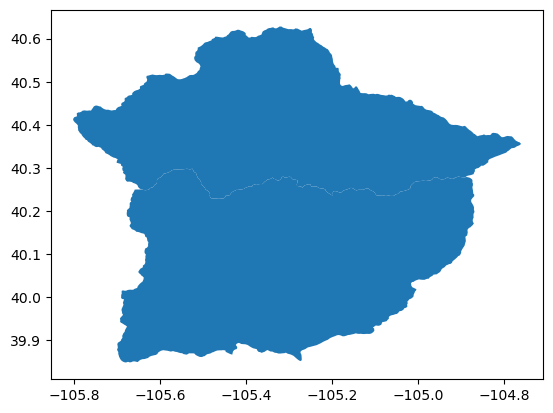

In [17]:
watershed_bound.plot()

<AxesSubplot:>

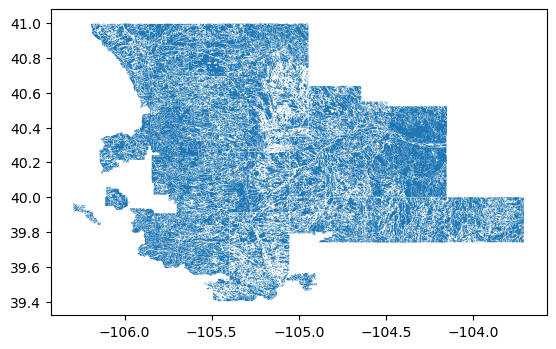

In [18]:
merged.plot()

<AxesSubplot:>

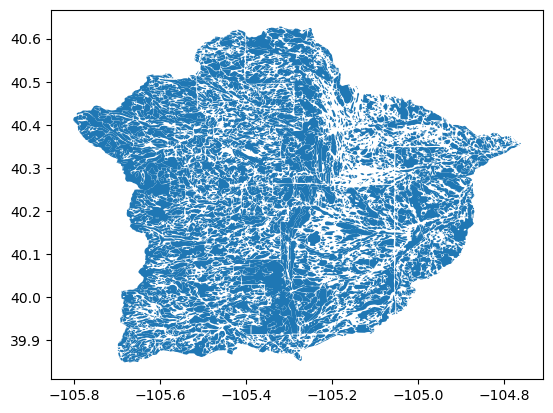

In [19]:
intersection = merged.overlay(watershed_bound, how='intersection')
intersection.plot()

**Part 2:**

Next we will determine the number of features in each watershed.

In [20]:
intersection.head(2)

,SPATIALVER,MUSYM,MUKEY,Shape_Length_1,Shape_Area_1,aws025wta,aws0150wta,drclassdcd,geometry_y,mapunit,STATES,NAME,Shape_Length_2,Shape_Area_2,HUC8,geometry
0,4.0,ReD,94068,0.027154,0.000019,4.15,12.23,Well drained,None,co001,CO,St. Vrain,2.675418,0.26807,10190005,"MULTIPOLYGON (((-105.039 39.973, -105.035 39.9..."
1,4.0,ReD,94068,0.009159,0.000004,4.15,12.23,Well drained,None,co001,CO,St. Vrain,2.675418,0.26807,10190005,"POLYGON ((-105.047 39.988, -105.047 39.991, -1..."


We need to groupby the "NAME" column to determine this.

In [21]:
group = intersection.groupby(["NAME"])["NAME"].count()
print(group)

NAME
Big Thompson    1979
St. Vrain       2073
Name: NAME, dtype: int64


There are 1,979 features in the Big Thompson watershed, and 2,073 features in the St. Vrain watershed.